In [144]:
import itertools
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from datetime import datetime
import random
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [145]:
dt = []
dt

[]

In [146]:
for i in range(0,1000):
 
    year = random.randint(2015, 2015)
    month = random.randint(1, 1)
    day = random.randint(1, 31)
    date1 = datetime(year, month, day)
    date1 = pd.to_datetime(date1)
    dt.append(date1)
dt[0:5], len(dt)

([Timestamp('2015-01-22 00:00:00'),
  Timestamp('2015-01-31 00:00:00'),
  Timestamp('2015-01-30 00:00:00'),
  Timestamp('2015-01-24 00:00:00'),
  Timestamp('2015-01-07 00:00:00')],
 1000)

In [147]:
index = random.sample(range(1000),1000)
vcounts = pd.DataFrame(index = index)
vcounts['video_id'] = np.random.randint(0,246,1000)
vcounts['view_count'] = np.random.randint(3000,20000,1000)
vcounts['date'] = dt
vcounts.head()

,video_id,view_count,date
283,59,18261,2015-01-22
606,87,17441,2015-01-31
114,50,12864,2015-01-30
100,221,12443,2015-01-24
880,78,13699,2015-01-07


In [148]:
dt2 = []
for i in range(0,1000):
 
    year = random.randint(2014, 2014)
    month = random.randint(12, 12)
    day = random.randint(1, 31)
    date2 = datetime(year, month, day)
    date2 = pd.to_datetime(date2)
    dt2.append(date2)
dt2[0:5], len(dt2)

([Timestamp('2014-12-27 00:00:00'),
  Timestamp('2014-12-28 00:00:00'),
  Timestamp('2014-12-28 00:00:00'),
  Timestamp('2014-12-17 00:00:00'),
  Timestamp('2014-12-24 00:00:00')],
 1000)

In [149]:
index2 = random.sample(range(1000),1000)
vfeatures = pd.DataFrame(index = index)
vfeatures['length'] = np.random.randint(100,1500,1000)
vfeatures['language'] = ['Es','Other','Fr','Gr'] * 250
vfeatures['upload_date'] = dt2
vfeatures['quality'] = ['240','1080','480','240','720'] * 200
vfeatures.head()

,length,language,upload_date,quality
283,557,Es,2014-12-27,240
606,100,Other,2014-12-28,1080
114,254,Fr,2014-12-28,480
100,1213,Gr,2014-12-17,240
880,384,Es,2014-12-24,720


In [150]:
def get_means(df):
    df = vcounts.groupby('video_id').describe(exclude=None).xs('mean',axis=1,level=1)
    return df.rename(columns = {'view_count': 'cnt_mean'})

def get_rch_means(df):
    df = vcounts.groupby(['video_id','date']).describe(exclude=None).groupby('video_id').\
pct_change().groupby('video_id').mean().\
xs('mean',axis=1,level=1)

    return df.rename(columns = {'view_count': 'rch_mean'})

def ext(df):
    
    df_means = get_means(df)
    
    df_rch_means= get_rch_means(df)
    
    return df_means.join(df_rch_means)


In [151]:
vstatistics = ext(vcounts)
vstatistics.head()

,cnt_mean,rch_mean
video_id,,
0,8979.000000,NaN
1,15223.600000,0.161210
2,12242.000000,-0.700563
3,9522.666667,0.125768
4,13467.666667,0.838242


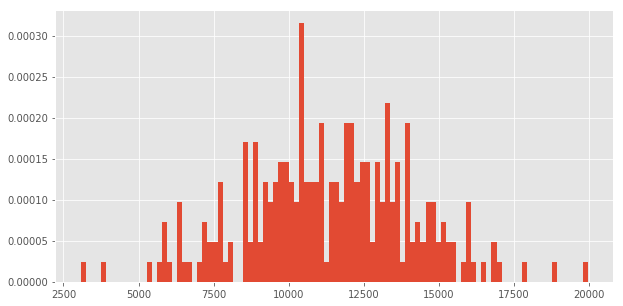

In [152]:
plt.figure(figsize=(10,5))
_ = plt.hist(vstatistics.cnt_mean,bins=100,normed=True)

In [153]:
cnt_cutoff = 14000
(vstatistics.cnt_mean >= cnt_cutoff).mean()

0.1598360655737705

In [154]:
vstatistics['is_popular'] = vstatistics.cnt_mean >= cnt_cutoff
vstatistics.head()

,cnt_mean,rch_mean,is_popular
video_id,,,
0,8979.000000,NaN,False
1,15223.600000,0.161210,True
2,12242.000000,-0.700563,False
3,9522.666667,0.125768,False
4,13467.666667,0.838242,False


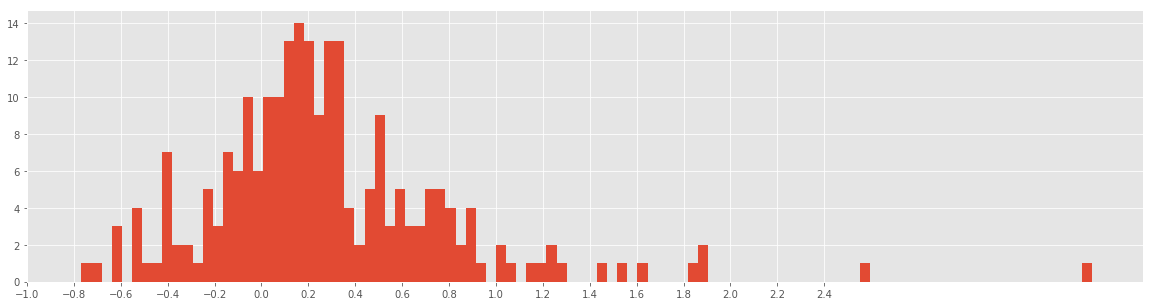

In [155]:
plt.figure(figsize=(20,5))
plt.hist(vstatistics.rch_mean.dropna(), bins = 100)
_ = plt.xticks(np.arange(-1,2.5,.2))

In [156]:
rch_bins = [-100,-.05,.05,100]
vstatistics['trend_status'] = pd.cut(vstatistics.rch_mean,rch_bins,right=False,labels=['decrease','flat','increase'])

In [157]:
vstatistics.trend_status.value_counts()

increase    157
decrease     52
flat         17
Name: trend_status, dtype: int64

In [158]:
videos = vfeatures
videos = videos.join(vstatistics.loc[:,['is_popular','trend_status']])

In [159]:
videos.sort_index().head()

,length,language,upload_date,quality,is_popular,trend_status
0,819,Gr,2014-12-26,240,False,NaN
1,319,Fr,2014-12-28,240,True,increase
2,306,Gr,2014-12-14,480,False,decrease
3,1141,Es,2014-12-26,720,False,increase
4,931,Gr,2014-12-29,240,False,increase


In [160]:
status = pd.Series('Everything else',index = videos.index)
status.loc[ videos.trend_status == 'increase'] = 'Hot'
status.loc[ (videos.trend_status == 'flat') & videos.is_popular] = 'Stable and Popular'

In [161]:
status

283    Everything else
606    Everything else
114                Hot
100    Everything else
880    Everything else
45     Everything else
829    Everything else
948    Everything else
788    Everything else
603    Everything else
170                Hot
495    Everything else
320    Everything else
821    Everything else
257    Everything else
339    Everything else
271    Everything else
440    Everything else
532    Everything else
995    Everything else
662    Everything else
97                 Hot
414    Everything else
371    Everything else
253    Everything else
523    Everything else
946    Everything else
875    Everything else
129                Hot
686    Everything else
            ...       
542    Everything else
466    Everything else
605    Everything else
103    Everything else
796    Everything else
154    Everything else
110    Everything else
572    Everything else
513    Everything else
571    Everything else
656    Everything else
504    Everything else
411    Ever

In [162]:
status.value_counts()

Everything else       839
Hot                   157
Stable and Popular      4
dtype: int64

In [163]:
videos.groupby(status).apply(lambda df: df.shape[0])

Everything else       839
Hot                   157
Stable and Popular      4
dtype: int64

In [164]:
X = videos.copy()
X.head()

,length,language,upload_date,quality,is_popular,trend_status
283,557,Es,2014-12-27,240,NaN,NaN
606,100,Other,2014-12-28,1080,NaN,NaN
114,254,Fr,2014-12-28,480,False,increase
100,1213,Gr,2014-12-17,240,True,decrease
880,384,Es,2014-12-24,720,NaN,NaN


In [165]:
X['is_hot'] = (X.trend_status == 'increase').astype(int)
del X['is_popular']
del X['trend_status']

In [166]:

X['upload_weekday'] = X.upload_date.dt.weekday_name
del X['upload_date']

In [167]:

X.head()

,length,language,quality,is_hot,upload_weekday
283,557,Es,240,0,Saturday
606,100,Other,1080,0,Sunday
114,254,Fr,480,1,Sunday
100,1213,Gr,240,0,Wednesday
880,384,Es,720,0,Wednesday


In [168]:
weekday_hot = X.groupby(by='is_hot').apply(lambda df: df.upload_weekday.value_counts(normalize=True)).unstack()
weekday_hot

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
is_hot,,,,,,,
0,0.128114,0.155397,0.138790,0.126928,0.128114,0.150652,0.172005
1,0.140127,0.114650,0.159236,0.210191,0.089172,0.146497,0.140127


In [169]:
weekday_hot.loc[:,["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]]

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
is_hot,,,,,,,
0,0.126928,0.155397,0.150652,0.172005,0.128114,0.128114,0.138790
1,0.210191,0.114650,0.146497,0.140127,0.089172,0.140127,0.159236


In [170]:
X.head()

,length,language,quality,is_hot,upload_weekday
283,557,Es,240,0,Saturday
606,100,Other,1080,0,Sunday
114,254,Fr,480,1,Sunday
100,1213,Gr,240,0,Wednesday
880,384,Es,720,0,Wednesday


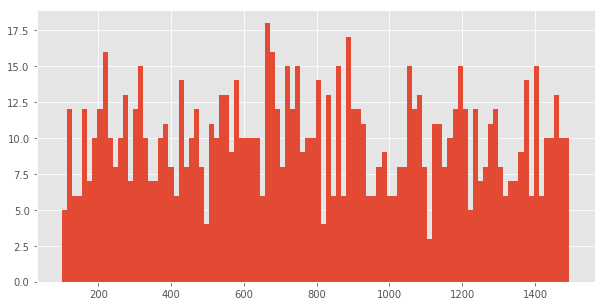

In [171]:
plt.figure(figsize = (10,5))
_ = plt.hist(X.length, bins = 100)

In [172]:
length_bins = [0,500,1000,1500]
X['length_bins'] = pd.cut(X.length,length_bins, right = False, labels = ['short','medium','long'])
length_hot = X.groupby('is_hot').apply(lambda df: df.length_bins.value_counts(normalize=True))
length_hot = length_hot.loc[:,['short','medium','long']]
length_hot

length_bins,short,medium,long
is_hot,,,
0,0.282325,0.380783,0.336892
1,0.242038,0.394904,0.363057


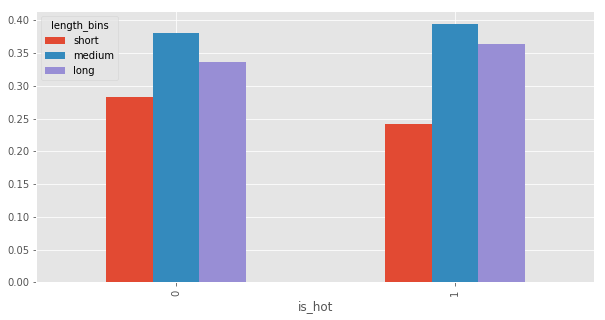

In [173]:
length_hot.plot(kind='bar',figsize=(10,5))

In [174]:
language_hot = X.groupby(by='is_hot').apply(lambda df: df.language.value_counts(normalize=True)).unstack()
language_hot

,Es,Fr,Gr,Other
is_hot,,,,
0,0.239620,0.251483,0.245552,0.263345
1,0.305732,0.242038,0.273885,0.178344


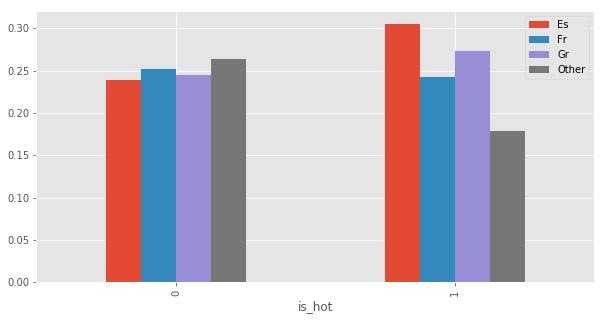

In [175]:
language_hot.plot(kind='bar',figsize=(10,5))

In [176]:
y = X.is_hot
del X['is_hot']
X = pd.get_dummies(X,columns=['language','upload_weekday', 'length_bins'],prefix='',prefix_sep='')

In [177]:
X.head()

,length,quality,Es,Fr,Gr,Other,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,short,medium,long
283,557,240,1,0,0,0,0,0,1,0,0,0,0,0,1,0
606,100,1080,0,0,0,1,0,0,0,1,0,0,0,1,0,0
114,254,480,0,1,0,0,0,0,0,1,0,0,0,1,0,0
100,1213,240,0,0,1,0,0,0,0,0,0,0,1,0,0,1
880,384,720,1,0,0,0,0,0,0,0,0,0,1,1,0,0


In [178]:
#delete redundant features
del X['Other']
X.head()

,length,quality,Es,Fr,Gr,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,short,medium,long
283,557,240,1,0,0,0,0,1,0,0,0,0,0,1,0
606,100,1080,0,0,0,0,0,0,1,0,0,0,1,0,0
114,254,480,0,1,0,0,0,0,1,0,0,0,1,0,0
100,1213,240,0,0,1,0,0,0,0,0,0,1,0,0,1
880,384,720,1,0,0,0,0,0,0,0,0,1,1,0,0


In [179]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 20, min_samples_split = 20)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [180]:
feat_importances = pd.Series(dt.feature_importances_, index = X.columns)
feat_importances.sort_values(ascending = False, inplace = True)
feat_importances

length       0.593474
Sunday       0.171606
quality      0.120291
Es           0.070115
Thursday     0.044513
long         0.000000
medium       0.000000
short        0.000000
Wednesday    0.000000
Tuesday      0.000000
Saturday     0.000000
Monday       0.000000
Friday       0.000000
Gr           0.000000
Fr           0.000000
dtype: float64

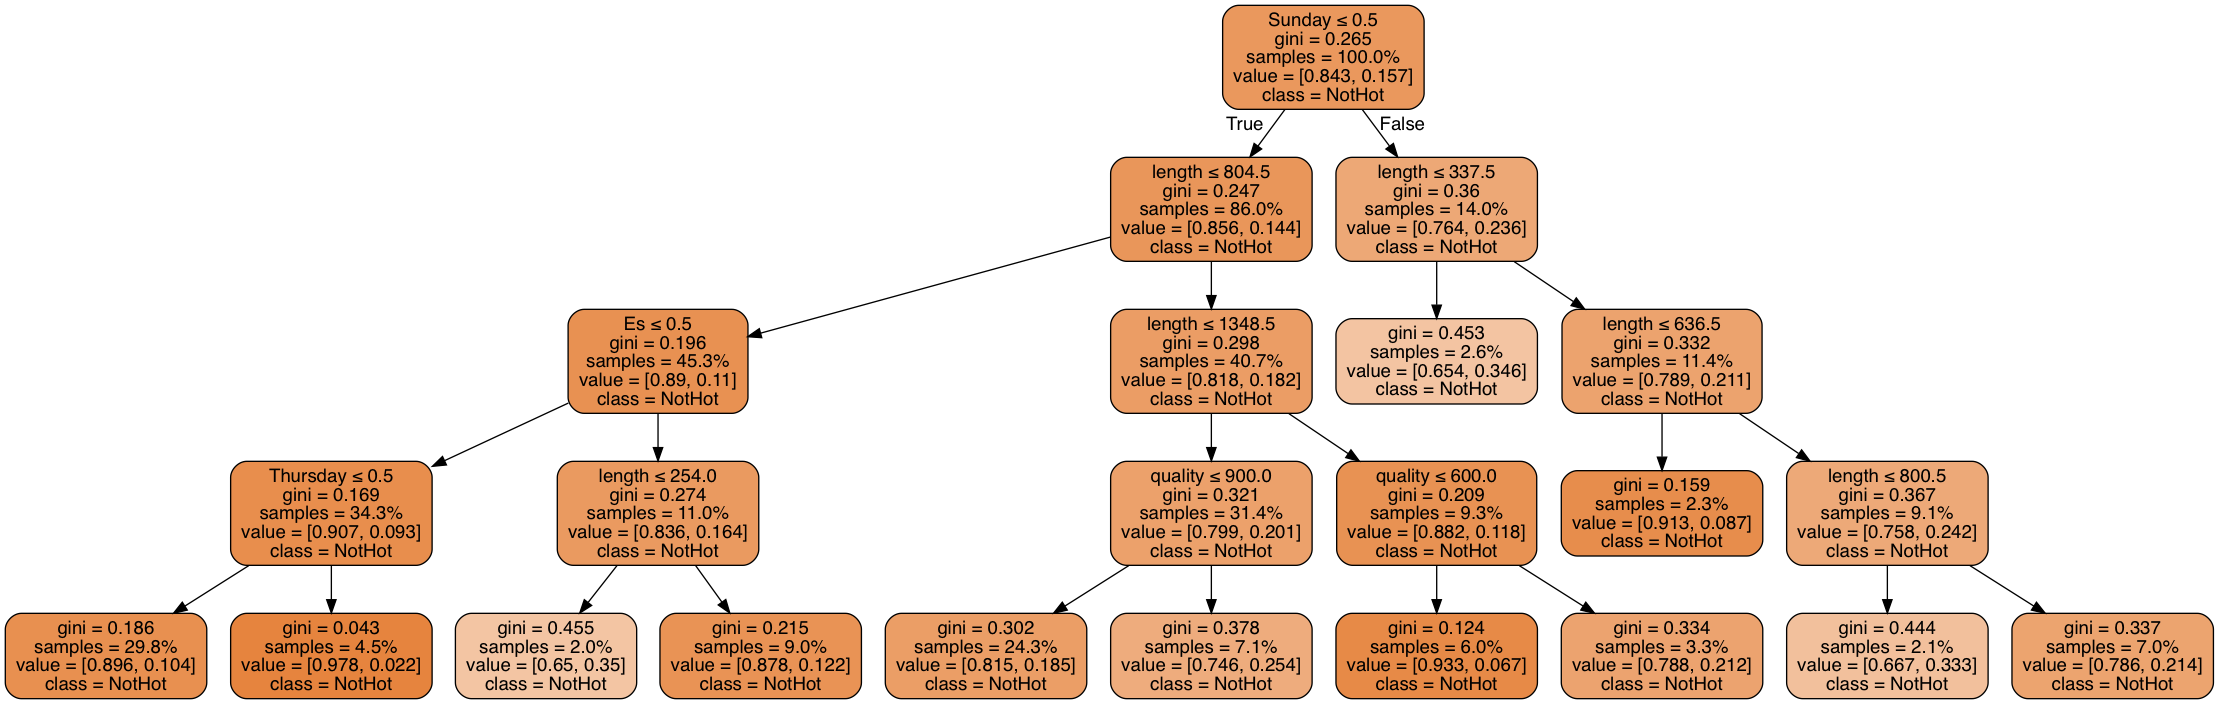

In [181]:
dot_data = StringIO()
export_graphviz(dt,rounded = True, class_names = ['NotHot','Hot'], proportion = True, feature_names = X.columns,filled=True, out_file = dot_data, special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())